# Classifying cancer expression vectors

In this assignment you will train a neural network to identify the tissue type that produced an RNA expression vector. The dataset is comprised of RNA-seq data obtained from tumors. 

For a complete description of the data collection workflow see this page:
https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net

And for the corresponding publication:
https://doi.org/10.1038/nbt.3772

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  1.0.1.post2


## Loading and parsing training data
For this problem, expression data needs to be loaded and pruned. Initially, there are >50,000 genes in each expression vector, which can be reduced to a much smaller gene set for the sake of minimizing computation time. Here, the data is subsetted to only include genes from the KEGG gene set. You may want to consider reducing or expanding this dataset to get a better understanding of which genes are predictive, though this is not a requirement for the assignment.

For a list of gene sets, check out the MSigDB collections page: http://software.broadinstitute.org/gsea/msigdb/collections.jsp

This script was adapted from Rob Currie's ingestion script: https://github.com/rcurrie/tumornormal/blob/master/genesets.ipynb

We have placed a subset of this data for this homework in Google drive, you can download it here:

https://drive.google.com/drive/folders/1pPABQDEHCddPTJAhfD6G5KyBDJiK3unQ?usp=sharing

In [2]:
# Load the data - If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#x_test: https://drive.google.com/file/d/1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW/view?usp=sharing
#x_train: https://drive.google.com/file/d/1s8VvRaUc62OYukRunV689Y9u-v_y7KRl/view?usp=sharing
#y_test: https://drive.google.com/file/d/1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2/view?usp=sharing
#t_train: https://drive.google.com/file/d/1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD/view?usp=sharing

# 2. Now proxy the Google Drive files to a local file
x_test_import = drive.CreateFile({'id':'1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW'})
x_train_import = drive.CreateFile({'id':'1s8VvRaUc62OYukRunV689Y9u-v_y7KRl'})
y_test_import = drive.CreateFile({'id':'1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2'})
y_train_import = drive.CreateFile({'id':'1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD'})

x_test_import.GetContentFile('x_test.npz') # x_test.npz is the file name that will be accessible in the notebook.
x_train_import.GetContentFile('x_train.npz') # x_train.npz is the file name that will be accessible in the notebook.
y_test_import.GetContentFile('y_test.npz') # y_test.npz is the file name that will be accessible in the notebook.
y_train_import.GetContentFile('y_train.npz') # y_train.npz is the file name that will be accessible in the notebook.

y_index_key = {'Adipose Tissue': 0, 'Adrenal Gland': 1, 'Adrenal gland': 2, 'Bile duct': 3, 'Bladder': 4, 'Blood': 5, 'Blood Vessel': 6, 'Bone Marrow': 7, 'Brain': 8, 'Breast': 9, 'Cervix': 10, 'Cervix Uteri': 11, 'Colon': 12, 'Endometrium': 13, 'Esophagus': 14, 'Eye': 15, 'Fallopian Tube': 16, 'Head and Neck region': 17, 'Heart': 18, 'Kidney': 19, 'Lining of body cavities': 20, 'Liver': 21, 'Lung': 22, 'Lymphatic tissue': 23, 'Muscle': 24, 'Nerve': 25, 'Ovary': 26, 'Pancreas': 27, 'Paraganglia': 28, 'Pituitary': 29, 'Prostate': 30, 'Rectum': 31, 'Salivary Gland': 32, 'Skin': 33, 'Small Intestine': 34, 'Soft tissue,Bone': 35, 'Spleen': 36, 'Stomach': 37, 'SympatheticÊNervous System': 38, 'Testis': 39, 'Thymus': 40, 'Thyroid': 41, 'Thyroid Gland': 42, 'Uterus': 43, 'Vagina': 44, 'White blood cell': 45}

for name in y_index_key:
  print(name, y_index_key[name])

    100% |████████████████████████████████| 993kB 21.4MB/s 
Adipose Tissue 0
Adrenal Gland 1
Adrenal gland 2
Bile duct 3
Bladder 4
Blood 5
Blood Vessel 6
Bone Marrow 7
Brain 8
Breast 9
Cervix 10
Cervix Uteri 11
Colon 12
Endometrium 13
Esophagus 14
Eye 15
Fallopian Tube 16
Head and Neck region 17
Heart 18
Kidney 19
Lining of body cavities 20
Liver 21
Lung 22
Lymphatic tissue 23
Muscle 24
Nerve 25
Ovary 26
Pancreas 27
Paraganglia 28
Pituitary 29
Prostate 30
Rectum 31
Salivary Gland 32
Skin 33
Small Intestine 34
Soft tissue,Bone 35
Spleen 36
Stomach 37
SympatheticÊNervous System 38
Testis 39
Thymus 40
Thyroid 41
Thyroid Gland 42
Uterus 43
Vagina 44
White blood cell 45


## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data has been stored in numpy format, which conveniently pytorch has a method for converting to their native format.

In [0]:
class PrimarySiteDataset(Dataset):
    def __init__(self, x_path, y_path, batch_size=None):
        x = np.load(x_path)['a']
        y = np.load(y_path)['a']

        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

## Define training methods for the model
These methods use an initialized model and training data to iteratively perform the forward and backward pass of optimization. Aside from some data reformatting that depends on the input, output, and loss function, these methods will always be the same for any shallow neural network.

In [0]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    
    max_values, target_index = y.max(dim=1) 
    target_index = target_index.type(torch.LongTensor)

    loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()


def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses



**Define method for running testing data**

In [0]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict


def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y, y_predict_vector

**Method for plotting loss**

In [0]:
def plot_loss(losses, show=True):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)

    if show:
        pyplot.show()

    pyplot.close()

**Define architecture of the Neural Network**

In [0]:
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()
        
        # Define network layer dimensions
        D_in, H1, H2, H3, D_out = [5172, 5000, 2500, 1000, 46]    # These numbers correspond to each layer: [input, hidden_1, output]
        
        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1,H2)
        self.linear3 = nn.Linear(H2,H3)
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = torch.relu(x)       # activation function       
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        x = torch.relu(x)
        x = self.linear4(x)  # output layer
        
        x = F.log_softmax(x,dim=1)
        
        return x

**Define function that runs the model and handles the flow of data**

In [0]:
def run(dataset_train, dataset_test):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 16 #what should it be
    
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 1e-2
    shallow_model = ShallowLinear()
    
    n_epochs = 4
    
    # Initialize the optimizer with above parameters
    optimizer = optim.SGD(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.MSELoss()  # mean squared error

    # Train and get the resulting loss per iteration
    loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn, epochs=n_epochs)
    
    # Test and get the resulting predicted y values
    y_true,y_predict = test(model=shallow_model, loader=data_loader_test)

    return loss, y_true, y_predict

**Run the model**

In [15]:
x_train_path = "x_train.npz"
y_train_path = "y_train.npz"
x_test_path = "x_test.npz"
y_test_path = "y_test.npz"
dataset_train = PrimarySiteDataset(x_path=x_train_path,y_path=y_train_path)
dataset_test = PrimarySiteDataset(x_path=x_test_path,y_path=y_test_path)

loss_vals,y_true_vals, y_predict_vals = run(dataset_train,dataset_test)


Epoch:  1
Batches:  957
Epoch:  2
Batches:  1914
Epoch:  3
Batches:  2871
Epoch:  4
Batches:  3828


**Visualize true & prediction vectors**

In [17]:
#table from part 3 #4
temp_predict = y_predict_vals[0]
temp_true = y_true_vals[0]
df = pd.DataFrame({"y_predict":temp_predict, "y":temp_true})
df.head()

,y,y_predict
0,0.0,-3.835088
1,0.0,-3.847821
2,0.0,-3.822056
3,0.0,-3.844101
4,0.0,-3.837542


**Check result of loss function**

In [82]:
#see if loss funciton is no longer NaN
print(loss_vals[-1])
print(y_predict_vals.shape)

14.845046043395996
(3826, 46)


**Find prediction accuracy**

In [74]:
#find argamax and print accuracy

true_argmax = np.argmax(y_true_vals,axis = 1)
pred_argmax = np.argmax(y_predict_vals, axis = 1)


counter = 0
for i in range(len(true_argmax)):
  if true_argmax[i] == pred_argmax[i]:
    counter += 1
print("Accuracy: ", 100*counter/len(pred_argmax),"%",sep="")




Accuracy: 90.46001045478306%


In [81]:
#print shape of argmax vectors
print(true_argmax.shape)
print(pred_argmax.shape)

torch.Size([3826])
(3826,)


**Histograms of true and predicted values**

Text(0, 0.5, 'Frequency')

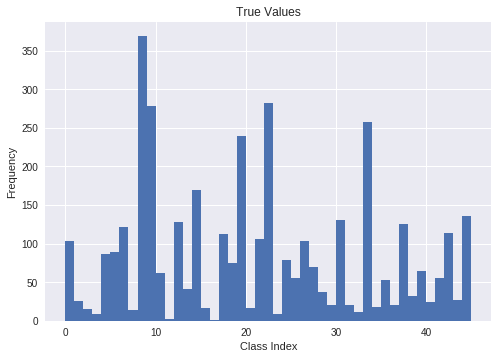

In [21]:
plt.hist(true_argmax,bins = range(min(true_argmax),max(true_argmax)+1,1))#edit this
plt.title("True Values")
plt.xlabel("Class Index")
plt.ylabel("Frequency")


Text(0, 0.5, 'Frequency')

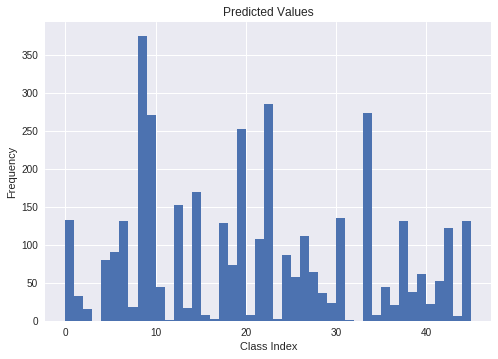

In [22]:
plt.hist(pred_argmax,bins = range(min(pred_argmax),max(pred_argmax)+1,1))#edit this
plt.title("Predicted Values")
plt.xlabel("Class Index")
plt.ylabel("Frequency")


**Visualize relationship between true and predicted values with a confusion matrix**

Normalized confusion matrix
[[0.99029126 0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.1        0.8        ... 0.         0.         0.        ]
 ...
 [0.05555556 0.         0.         ... 0.61111111 0.01851852 0.        ]
 [0.         0.         0.         ... 0.         0.67647059 0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


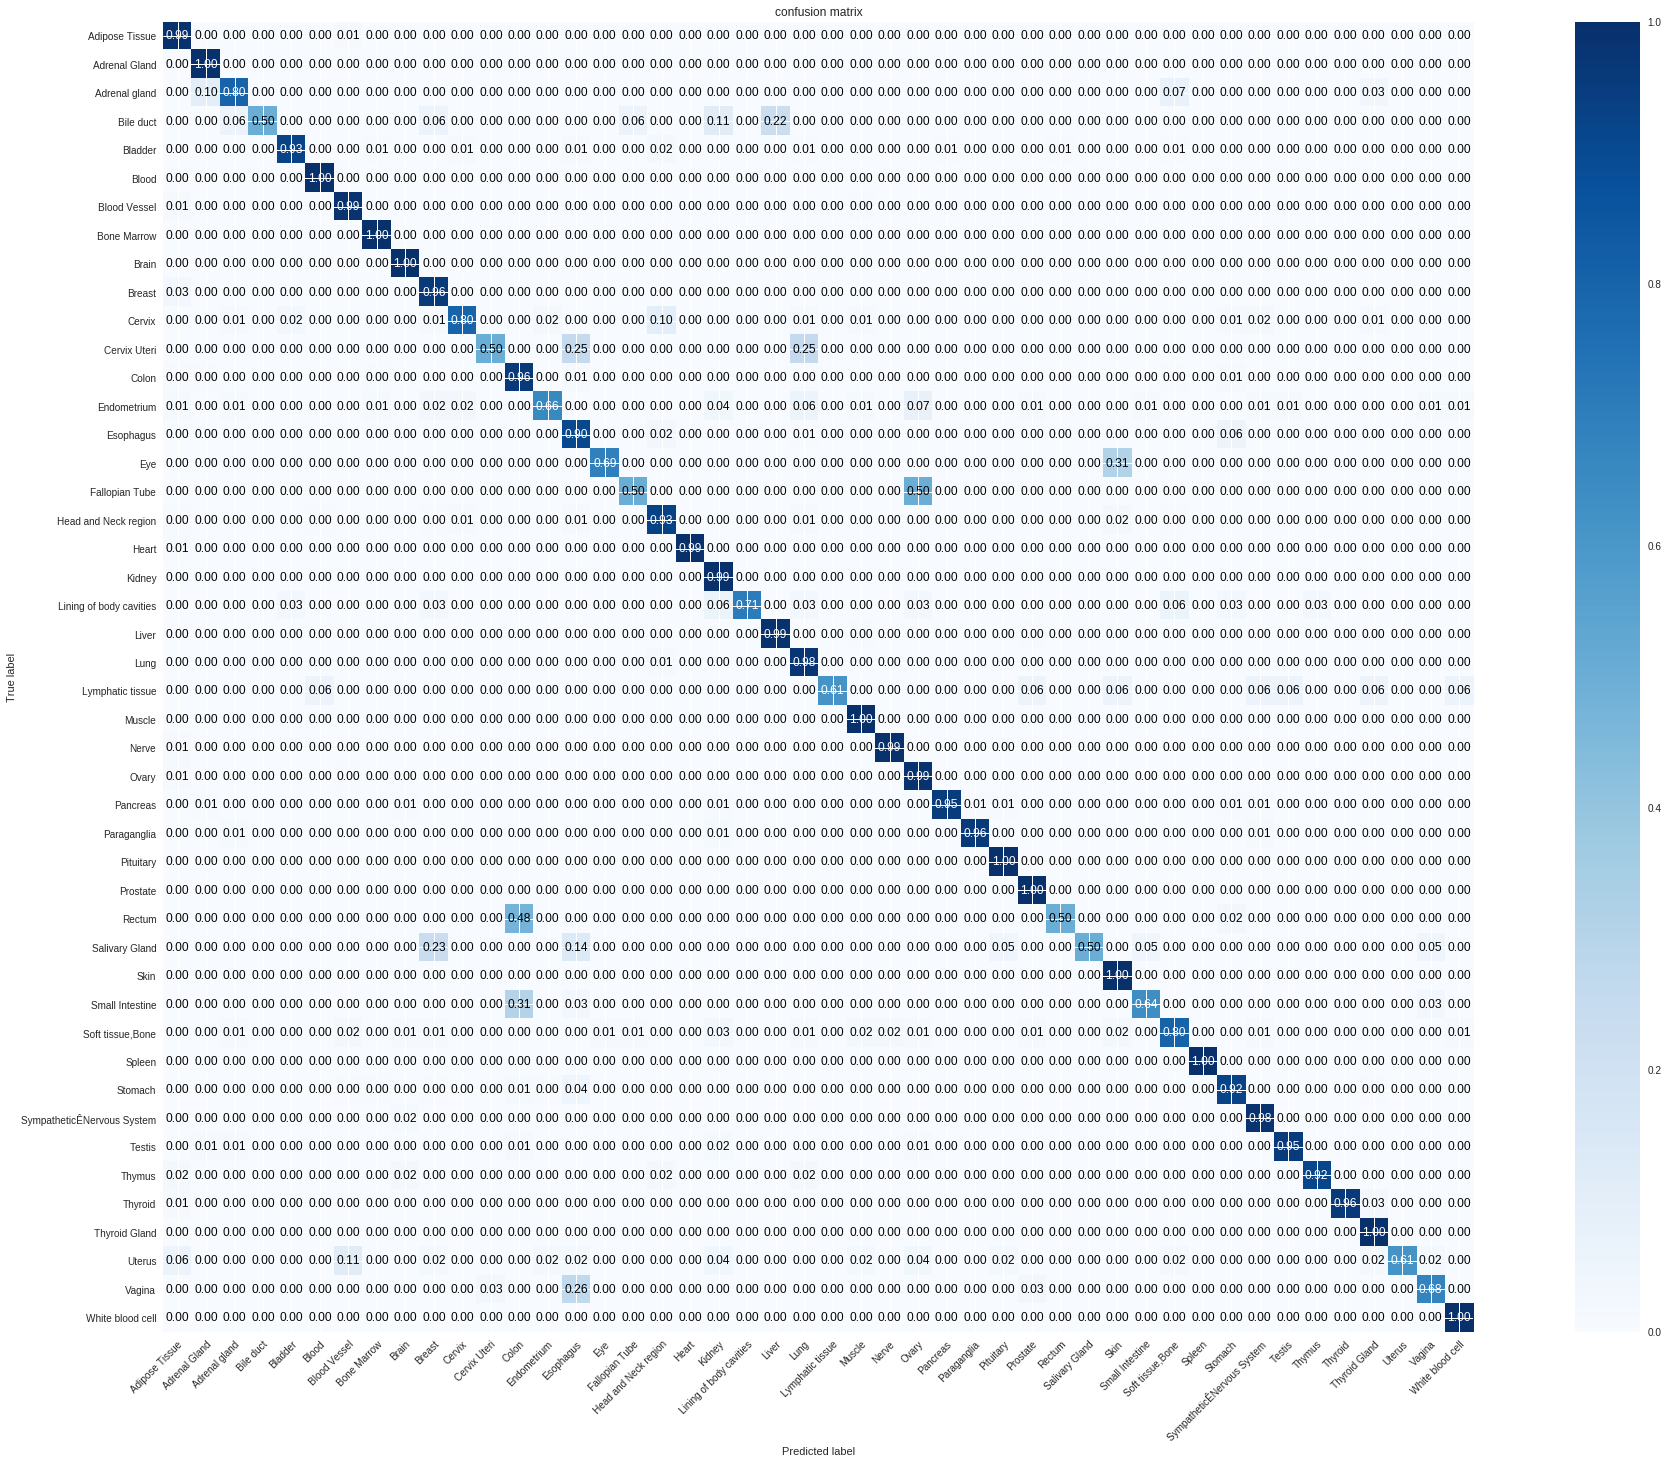

In [76]:
#some code adapted from Rick Tao

def plot_confusion_matrix(y, y_predict, classes, normalize=False,title=None,cmap=plt.cm.Blues):
  '''y is the true values numpy array, y_predict is the predction numpy array'''
  
  #compute the confusion matrix as a numpy array
  confused = np.zeros(shape=[len(y_index_key.keys()), len(y_index_key.keys())], dtype=int)
  for i in range(len(y)):
    confused[np.argmax(y[i])][np.argmax(y[i])]+=1
    confused[np.argmax(y[i])][np.argmax(y_predict[i])]+=1
  if not title:
    if normalize: title = 'Normalized confusion matrix'
    else: title = 'Confusion matrix, without normalization'
  if normalize:
    confused = confused.astype('float') / confused.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(confused)
  fig, ax = plt.subplots()
  im = ax.imshow(confused, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(confused.shape[1]),
         yticks=np.arange(confused.shape[0]),
         xticklabels=classes, yticklabels=classes,
         title='confusion matrix',
         ylabel='True label',
         xlabel='Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = confused.max() / 2.
  for i in range(confused.shape[0]):
    for j in range(confused.shape[1]):
      ax.text(j, i, format(confused[i, j], fmt), ha="center", va="center", color="white" if confused[i, j] > thresh else "black")
  fig.set_size_inches(28.5, 20.5,forward=True)
  fig.tight_layout()
  plt.show()
  return ax


plot_confusion_matrix(y_true_vals, y_predict_vals, classes = list(y_index_key.keys()), normalize = True, title = 'Confusion Matrix')

# Homework Questions

**Part 1**

1.   How many training examples are there in the data?

      There are 3826 training examples in the data
      
2.   What portion of the full dataset has been set aside for testing?

      15300/(3826+15300) * 100 = 80%
  
      80% of the data has been set aside for training      

3.   How many gene expression values will be used as input to classify each sample in the dataset?

 The number of values is equal to the size of the training set = 15300

4.   How many tissue types are there in the data labels (AKA the y vector)?

      There are 46 tissue types

5.   When performing classification with a neural network, the output vector is an array with n variables, where each variable describes the probability that your input belongs to one class in your classification problem. Based on this information, what should be the size of your output layer in the neural network?

  The output layer has to be of size 46.

6.   How will you know which index in the output corresponds to which tissue type once you feed your data into the model and get your output?

  The tissue types (class indices) have already been indexed before running the neural network.

**Part 2**

1.   Start by copying train(), train_batch(), test(), test_batch(), plot_loss(), run(), and the model class ShallowLinear into your notebook. Give each method and class an independent cell in your notebook. Include a very brief explanation about the purpose they serve, and very briefly describe each of their inputs and outputs (parameters and returned objects).

  train(): for the training data, computes the loss function values in each iteration
  
  train_batch(): for the training data, performs forward and backward passes
  
  test(): runs the model on the testing data
  
  test_batch(): performs forward calculation on the batch of testing data
  
  plot_loss(): plots the values of the loss function over time (at each iteration)
  
  run(): runs the neural network (analogous to a main function) by defining the training/testing splits, defining the hyperparameters, and running the model

2.   Draw a flowchart to describe the flow of information through this script, starting with x_train, y_train, x_test, y_test. You should be able to follow how the x and y vectors are used to create the final output of this notebook: results and figures.
  
  PrimarySiteDataset --> Run --> DataLoader --> ShallowLinear --> train --> train_batch --> ShallowLinear --> loss function & backward computation--> optimize --> test --> test_batch --> ShallowLinear --> prediction
  
  PrimarySiteDataset loads the data, and the 'run' is called. DataLoader takes x & y and returns the train/test split. Then, the 'run' function iniatializes ShallowLinear object/model with specified parameters. The 'train' function then takes the training set for each epoch, calls upon "train_batch" - which uses the ShallowLinear model to do forward calculations, compute loss, and optimize. Afterwards, the 'test' function is called to loop through the testing data and does the forward calculations in 'test_batch' to generated predicted values for y. Afterwards, one can calculate the accuracy and visualize the data with a confusion matrix. 
  
  

**Part 3**

2. The first step towards assessing your model will be to compare your predictions to their expected values. Edit your test methods so they return the true y vectors and the y prediction vectors back to your final code block. Print the shapes of these arrays to ensure they are exactly the same dimensions. What are their dimensions?

  (3826,46)
  
3. Do these match your training set size from part 1?

  Yes, it does match.

5. Now you can quickly compare whether there is a match or a mismatch between your model’s classificat true value. Print the shape of your argmax vectors to verify they have n entries. Write
the first value of y_argmax and y_predict_argmax and compare them to the table you made in #4. Does the relationship between these values and your #4 values make sense? 

  (shape printed in code)
  
  1st value of y_argmax: 8
  
  1st value of y_predict_argmax: 8

  Yes, this relationship makes sense because (given that this instance is accurate), the argmax of both the columns generated in number 4 should match. 

6. Add to your above method to calculate the percentage of matches between your predictions and known values. What is your overall classification accuracy?

  Overall classification accuracy is 90.46%

7. Plot a histogram of your argmax values for y, and for predicted y. How do they compare?

  They are mostly similar, reflective of the 90% accuracy of the model. There are small deviation that result from the 10% difference between the predicted and true values.

**Part 5**

2. Do you think there is a better combination of hyperparameters with respect to the test results? How might you find this combination?

  Given the accuracy, I would assume that one could find a better combination of hyperparameters. 
Ways to do so would include:

  grid search over all parameters
  
  optimization methods such as hyperband
  
  trial and error
  

3. What tissue types were most confusing for the model?

  The most confusing tissue types were the ones that deviated from the diagonal in the confusion matrix. Some of these include the eyes, ovariesa, esophagus, salivary glands, rectum, and small intestine.

4. How does each class’s frequency correlate to the model’s performance for that class, generally?

  The variance in accuracy is greater for lower frequency classes. Although, one would need to check in each instance. 














